In [1]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix,issparse
import pandas as pd
import seaborn as sns

In [2]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

2.1.2
11.8
True
1
0


In [4]:
method = ''
from g2g_model_Fisher import *

In [5]:
data_path = 'data/'
data_name = 'DG_bin'
# data_name = 'DG_new'
# data_name = 'A549_emt_bin'
# data_name = 'EG_bin'
# data_name = 'neural_bin'
# adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
adata0 = scv.read(data_path+data_name+'_ppt.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
[k_nei, K, L] = [10, 2, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'

result_path = 'results/'+data_name+','+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = 'figures/'
cmap = plt.colormaps['Spectral_r']

In [6]:
#-------data preprocessing
adata=adata0.copy()
scv.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [7]:
gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
# cell_vpt = adata.obs['velocity_pseudotime'].values#adata0.obs['latent_time'].values#
cell_vpt = adata.obs['palantir_pseudotime']
Xs = adata.layers['Ms']#adata.X.A#
velo0 = np.array(adata.layers['velocity'])
velo_g = np.zeros(velo0.shape)
velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
# velo_pca = velo_g@adata.varm['PCs']
velo_pca = adata.obsm['velocity_pca']

if norm=='standard':
    Xs_mean = np.mean(Xs,axis=0)
    Xs_std = np.std(Xs,axis=0)
    X = (Xs-Xs_mean)/Xs_std
    velo = velo_g/Xs_std
elif norm=='minmax':
    Xs_max = np.max(Xs,axis=0)
    Xs_min = np.min(Xs,axis=0)
    X = (Xs-Xs_min)/Xs_max
    velo = velo_g/Xs_max
else:
    X = Xs
#     velo = velo_g
    velo = velo_pca@adata.varm['PCs'].T

In [8]:
row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = adata.uns['neighbors']['indices'].flatten()
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

In [9]:
cell_nei = np.load(result_path+'cell_nei.npy')
nei_w = np.load(result_path+'nei_w.npy')

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

In [10]:
xsgn = -1
X_plt = xsgn*X_pca[:,0]
Y_plt = X_pca[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min
Y_ori = Y_min

In [11]:
crc = np.load(result_path+'crc.npy')
crc_eu = np.load(result_path+'crc_eu.npy')
crc_smooth = np.load(result_path+'crc_smooth.npy')

In [12]:
A=A_mat
# X=Xs
# X=Xs/np.mean(np.abs(Xs),axis=0)
# X=adata.X.A
#--------do not normalize X
# scaler=StandardScaler()#
# X=scaler.fit_transform(X0_ori)
z=cell_vpt

# encoder = Encoder(X.shape[1], L)
encoder = torch.load(result_path+'encoder.pt')

In [13]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

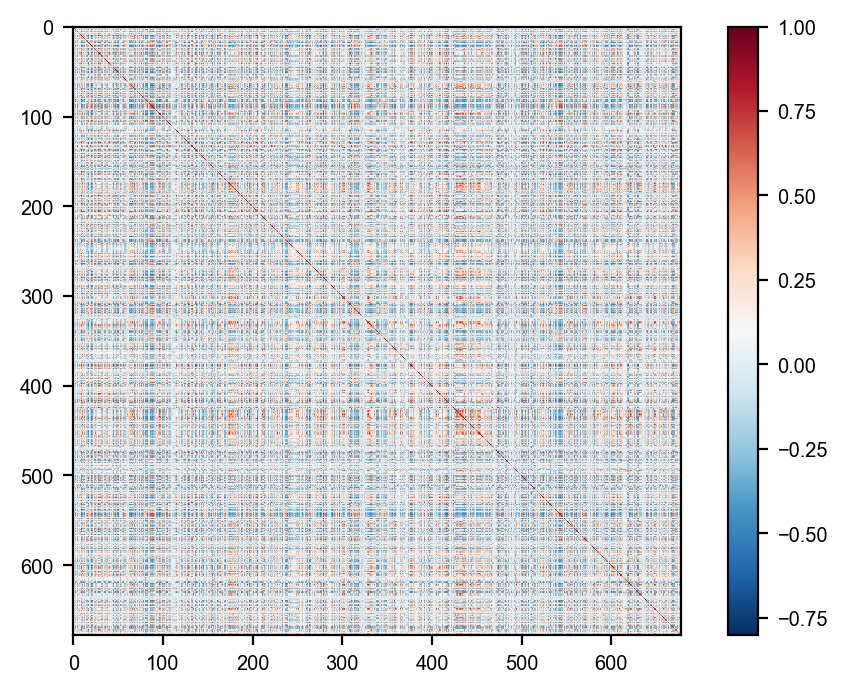

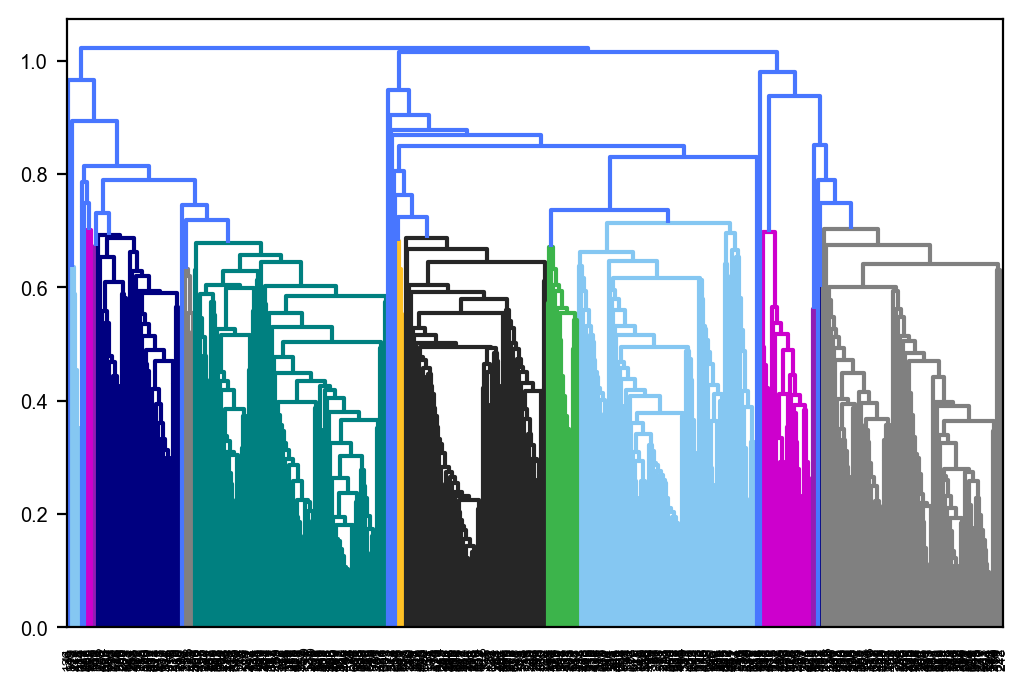

In [14]:
scaler=StandardScaler()#MinMaxScaler()#
X=scaler.fit_transform(Xs)

X_corr=np.corrcoef(X, rowvar=False)
plt.imshow(X_corr)
plt.colorbar()
plt.show()

Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg=dendrogram(Z)
X_re= X[:,dg['leaves']]#X_re reorder X by clustering

X_corr_re=np.corrcoef(X_re, rowvar=False)
plt.show()

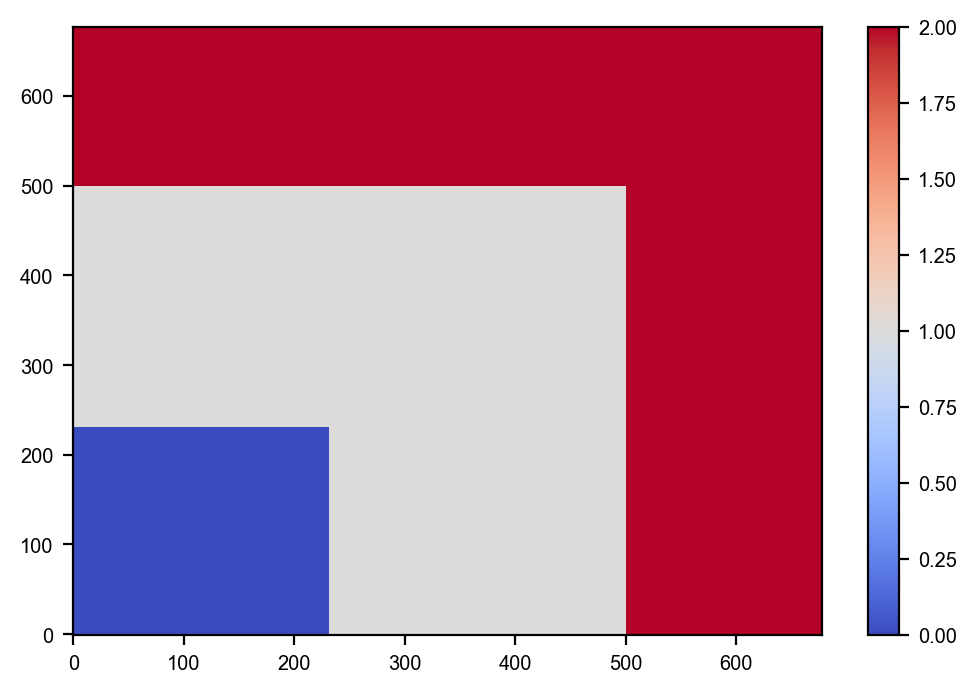

In [15]:
td=0.99
T=fcluster(Z, t=td, criterion='distance')
# T=fcluster(Z, t=td, criterion='maxclust')
T_re=T[dg['leaves']]

X_corr_label=X_corr_re.copy()
for i in range(X_corr_re.shape[0]):
    X_corr_label[:,i]=int(T_re[i]-1)
    X_corr_label[i,:]=int(T_re[i]-1)

plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')
plt.colorbar()
plt.show()

In [16]:
eg_label = np.zeros(Xs.shape[1])
eg_label[dg['leaves']] = np.diagonal(X_corr_label)
eg_label = np.array(eg_label,dtype=int)

In [17]:
crc_m0 = crc_eu-np.mean(crc_eu)
crc_m0 = smooth_func(crc_m0)

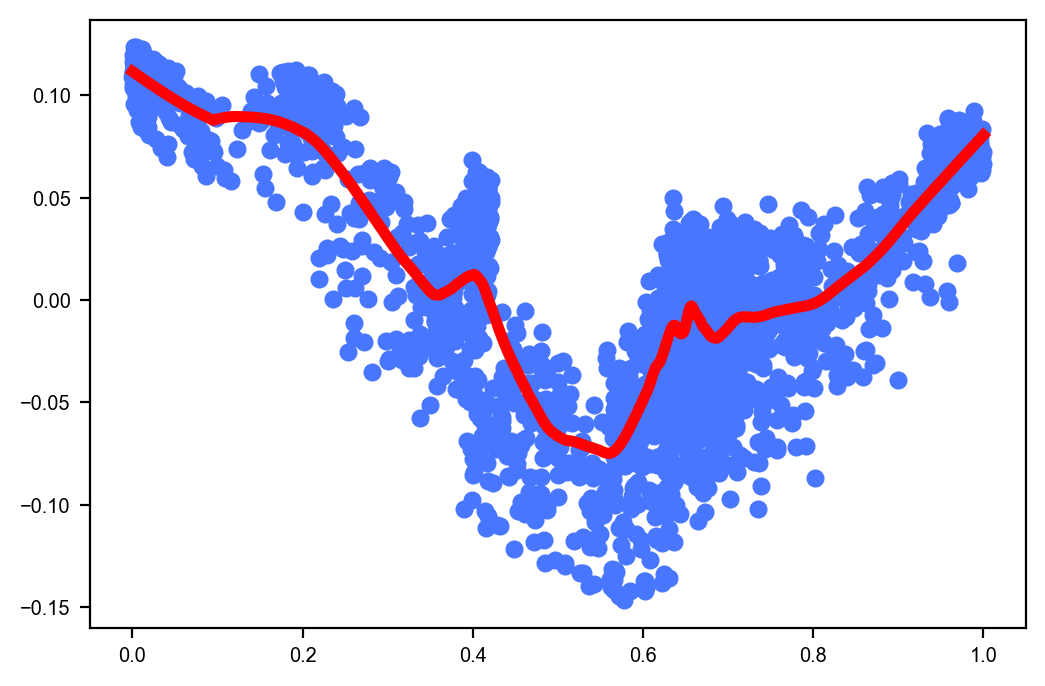

In [18]:
mask,vpt_kde,crc_kde = kde_lowess(cell_vpt,crc_m0,frac=0.1)
vpt_mask = cell_vpt[mask]
crc_mask = crc_m0[mask]
plt.scatter(vpt_mask,crc_mask)
plt.plot(vpt_kde,crc_kde,c='r',linewidth=4)

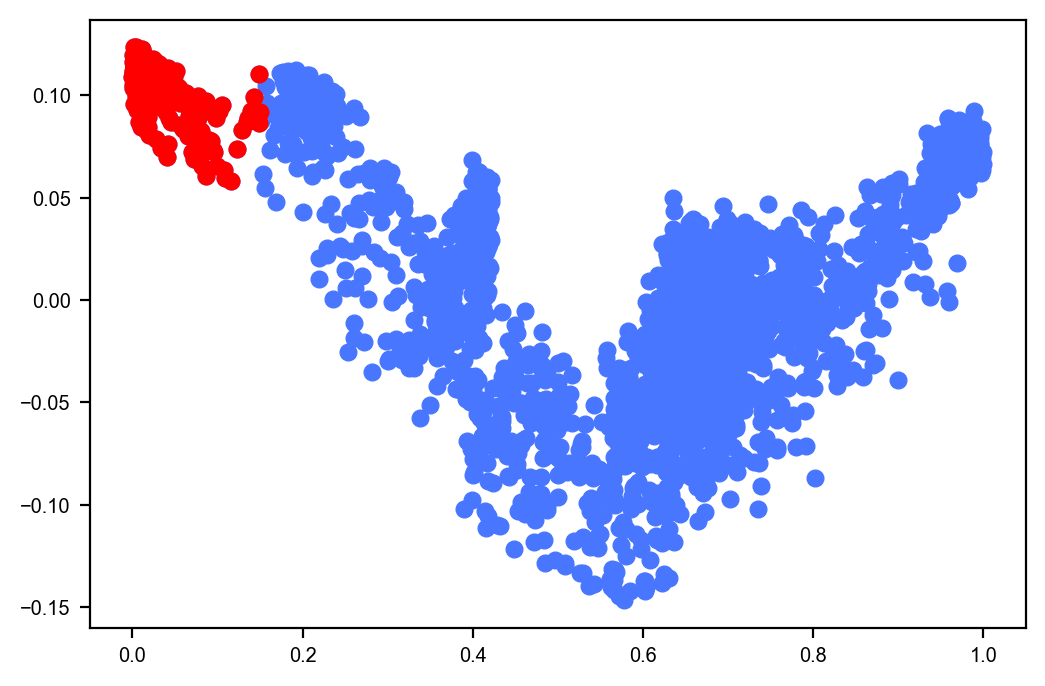

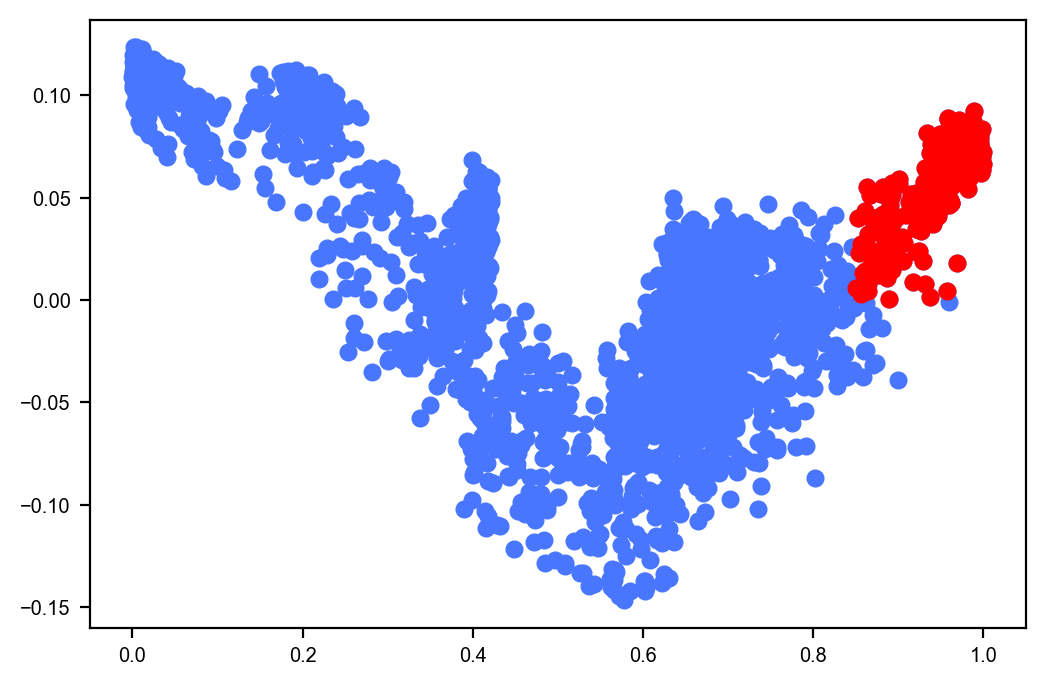

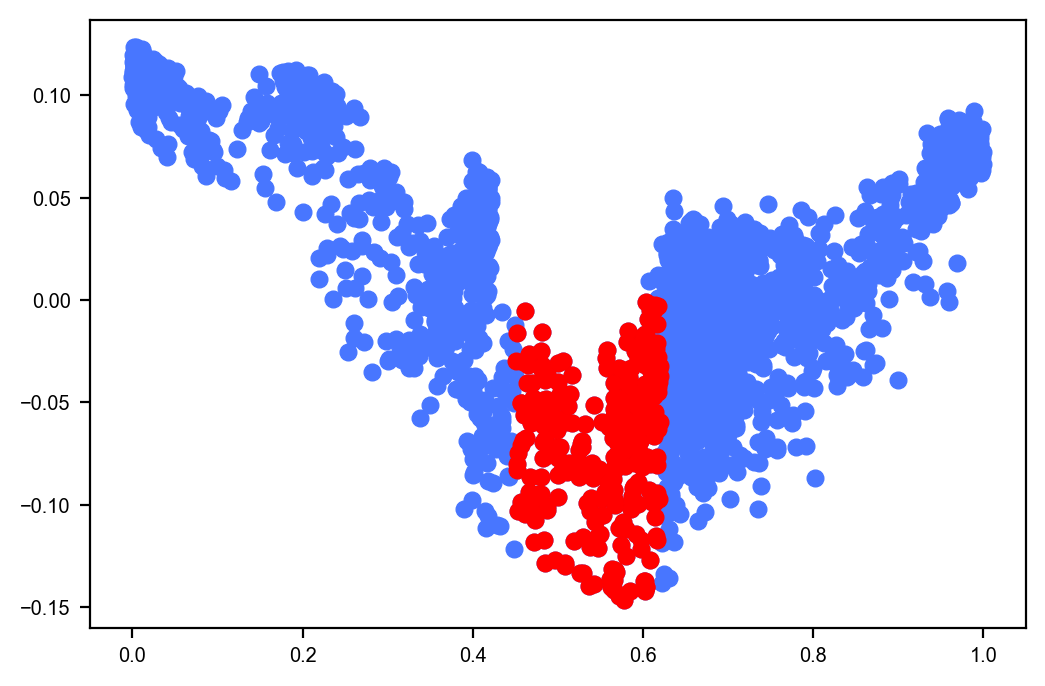

In [19]:
plt.scatter(cell_vpt[mask],crc_m0[mask])
max1 = np.logical_and(cell_vpt<0.15,crc_m0>0.05)
# max1 = cell_vpt<0.1
max1 = np.logical_and(mask,max1)
plt.scatter(cell_vpt[max1],crc_m0[max1],c='r')
plt.show()

plt.scatter(cell_vpt[mask],crc_m0[mask])
max2 = np.logical_and(cell_vpt>0.85,crc_m0>0)
# max2 = cell_vpt>0.85
max2 = np.logical_and(mask,max2)
plt.scatter(cell_vpt[max2],crc_m0[max2],c='r')
plt.show()

plt.scatter(cell_vpt[mask],crc_m0[mask])
min1 = np.logical_and(np.logical_and(0.45<cell_vpt,cell_vpt<0.62),crc_m0<0)
# min1 = np.logical_and(0.45<cell_vpt,cell_vpt<0.62)
min1 = np.logical_and(mask,min1)
plt.scatter(cell_vpt[min1],crc_m0[min1],c='r')
plt.show()

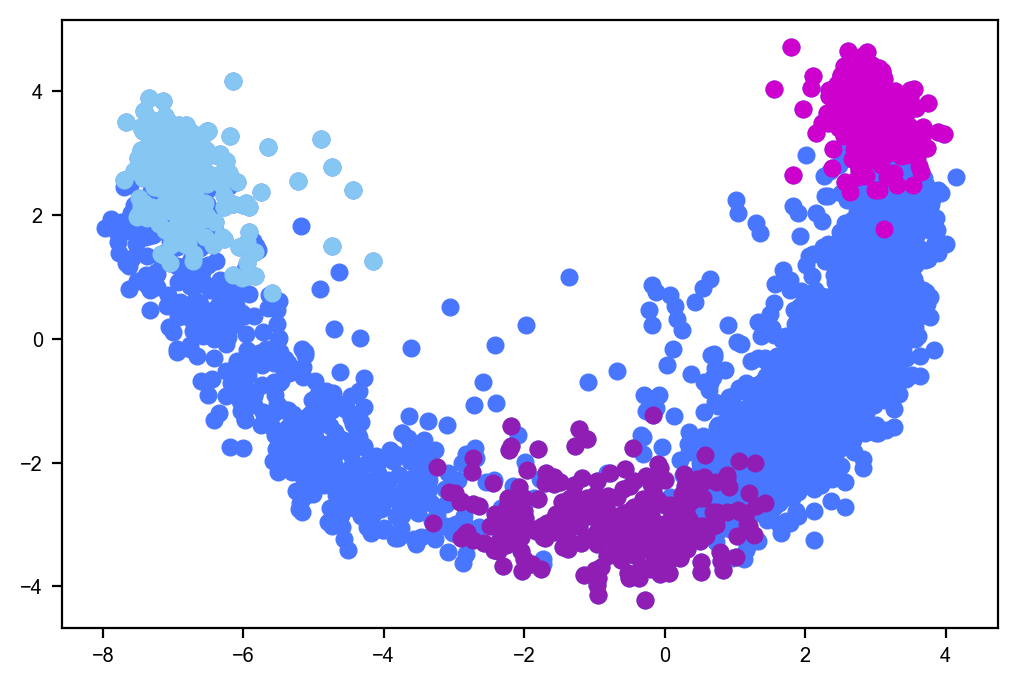

In [20]:
plt.scatter(X_plt,Y_plt)
plt.scatter(X_plt[max1],Y_plt[max1])
plt.scatter(X_plt[max2],Y_plt[max2])
plt.scatter(X_plt[min1],Y_plt[min1])

In [49]:
crow0 = np.array(sns.color_palette('muted')[:3])
crow1 = np.array(sns.color_palette('muted')[3:6])

In [22]:
cRc_gene_corr_max1=[]
for gi in range(Xs.shape[1]):
    cRc_gene_corr_max1.append(((Xs[:,gi]-np.mean(Xs[:,gi]))/np.std(Xs[:,gi]))[max1]@crc_m0[max1])
cRc_gene_corr_max1 = np.array(cRc_gene_corr_max1)
crc_cor_ind_max1 = np.argsort(np.abs(cRc_gene_corr_max1))[-20:]

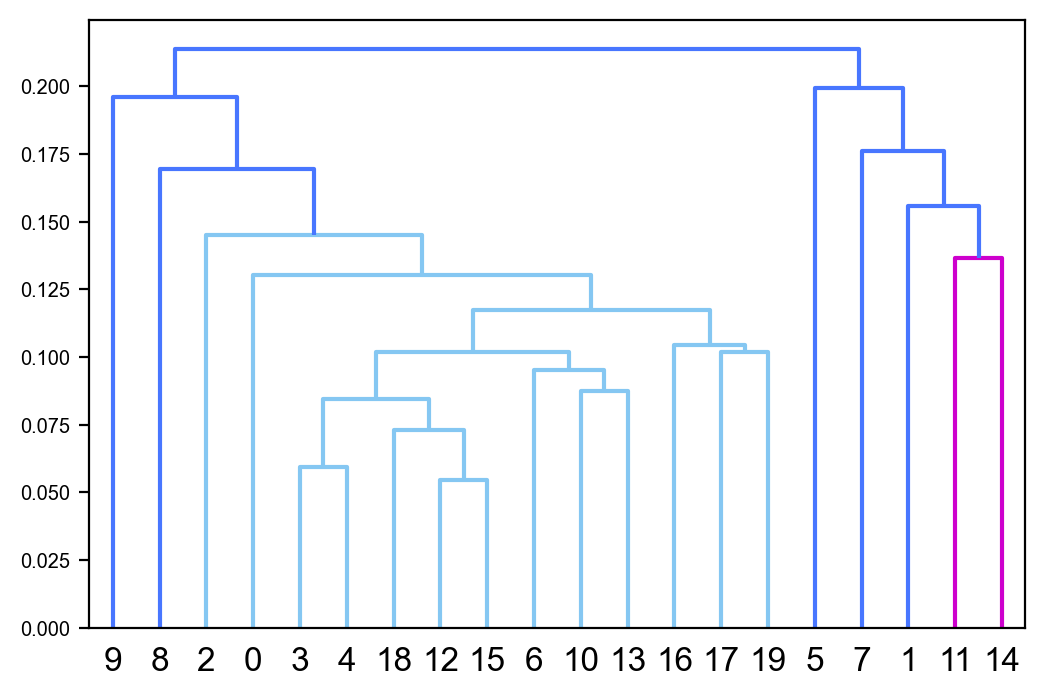

In [23]:
scaler = StandardScaler()#MinMaxScaler()#
X_tf = Xs[:,crc_cor_ind_max1]
X_tfs = scaler.fit_transform(X_tf)

X_corr = np.corrcoef(X_tfs, rowvar=False)
Z = linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg = dendrogram(Z)

crc_cor_ind_max1 = crc_cor_ind_max1[dg['leaves']]
X_tf = Xs[:,crc_cor_ind_max1]
cRc_keygene_max1 = gene_arr[crc_cor_ind_max1]
crow_max1 = crow[eg_label[crc_cor_ind_max1]]

In [25]:
cRc_gene_corr_max2=[]
for gi in range(Xs.shape[1]):
    cRc_gene_corr_max2.append(((Xs[:,gi]-np.mean(Xs[:,gi]))/np.std(Xs[:,gi]))[max2]@crc_m0[max2])
cRc_gene_corr_max2 = np.array(cRc_gene_corr_max2)
crc_cor_ind_max2 = np.argsort(np.abs(cRc_gene_corr_max2))[-20:]

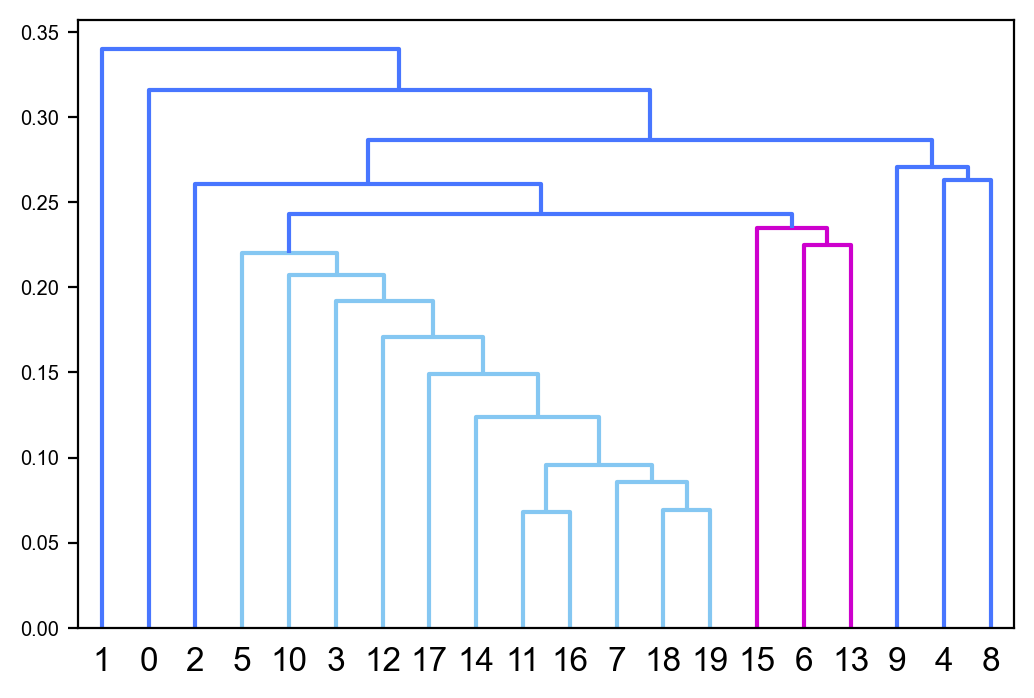

In [26]:
scaler = StandardScaler()#MinMaxScaler()#
X_tf = Xs[:,crc_cor_ind_max2]
X_tfs = scaler.fit_transform(X_tf)

X_corr = np.corrcoef(X_tfs, rowvar=False)
Z = linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg = dendrogram(Z)

crc_cor_ind_max2 = crc_cor_ind_max2[dg['leaves']]
X_tf = Xs[:,crc_cor_ind_max2]
cRc_keygene_max2 = gene_arr[crc_cor_ind_max2]
crow_max2 = crow[eg_label[crc_cor_ind_max2]]

In [39]:
cRc_gene_corr_min=[]
for gi in range(Xs.shape[1]):
    cRc_gene_corr_min.append(((Xs[:,gi]-np.mean(Xs[:,gi]))/np.std(Xs[:,gi]))[min1]@crc_m0[min1])
#     cRc_gene_corr_min.append((Xs[:,gi]/np.linalg.norm(Xs[:,gi]))[min1]@crc_m0[min1])
cRc_gene_corr_min = np.array(cRc_gene_corr_min)
crc_cor_ind_min = np.argsort(np.abs(cRc_gene_corr_min))[-20:]

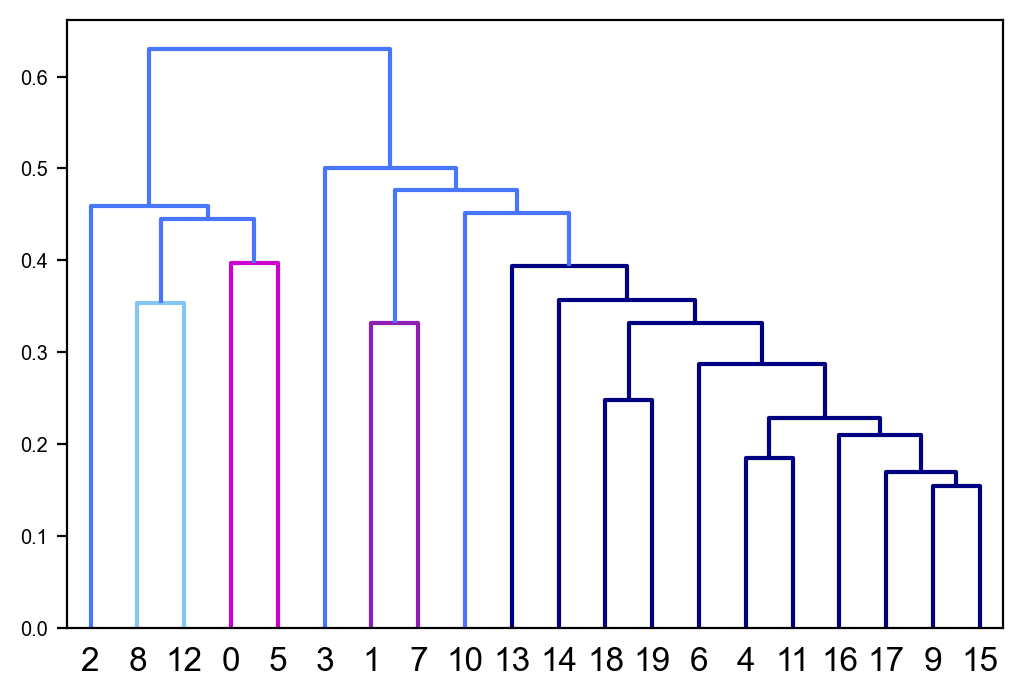

In [40]:
scaler = StandardScaler()#MinMaxScaler()#
X_tf = Xs[:,crc_cor_ind_min]
X_tfs = scaler.fit_transform(X_tf)

X_corr = np.corrcoef(X_tfs, rowvar=False)
Z = linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg = dendrogram(Z)

crc_cor_ind_min0 = crc_cor_ind_min[dg['leaves']]
crc_cor_ind_min = crc_cor_ind_min0.copy()
crc_cor_ind_min[1] = crc_cor_ind_min0[4]
crc_cor_ind_min[2] = crc_cor_ind_min0[3]
crc_cor_ind_min[3] = crc_cor_ind_min0[2]
crc_cor_ind_min[4] = crc_cor_ind_min0[1]
X_tf = Xs[:,crc_cor_ind_min]
cRc_keygene_min = gene_arr[crc_cor_ind_min]
crow_min = crow[eg_label[crc_cor_ind_min]]

In [59]:
crc_cor_ind = np.concatenate((np.concatenate((crc_cor_ind_max1,crc_cor_ind_min)),crc_cor_ind_max2))

X_tf = Xs[:,crc_cor_ind]

cRc_keygene = gene_arr[crc_cor_ind]
crow_eg = crow1[eg_label[crc_cor_ind]]
crow_cor = crow2[np.array([0]*20+[1]*20+[2]*20)]

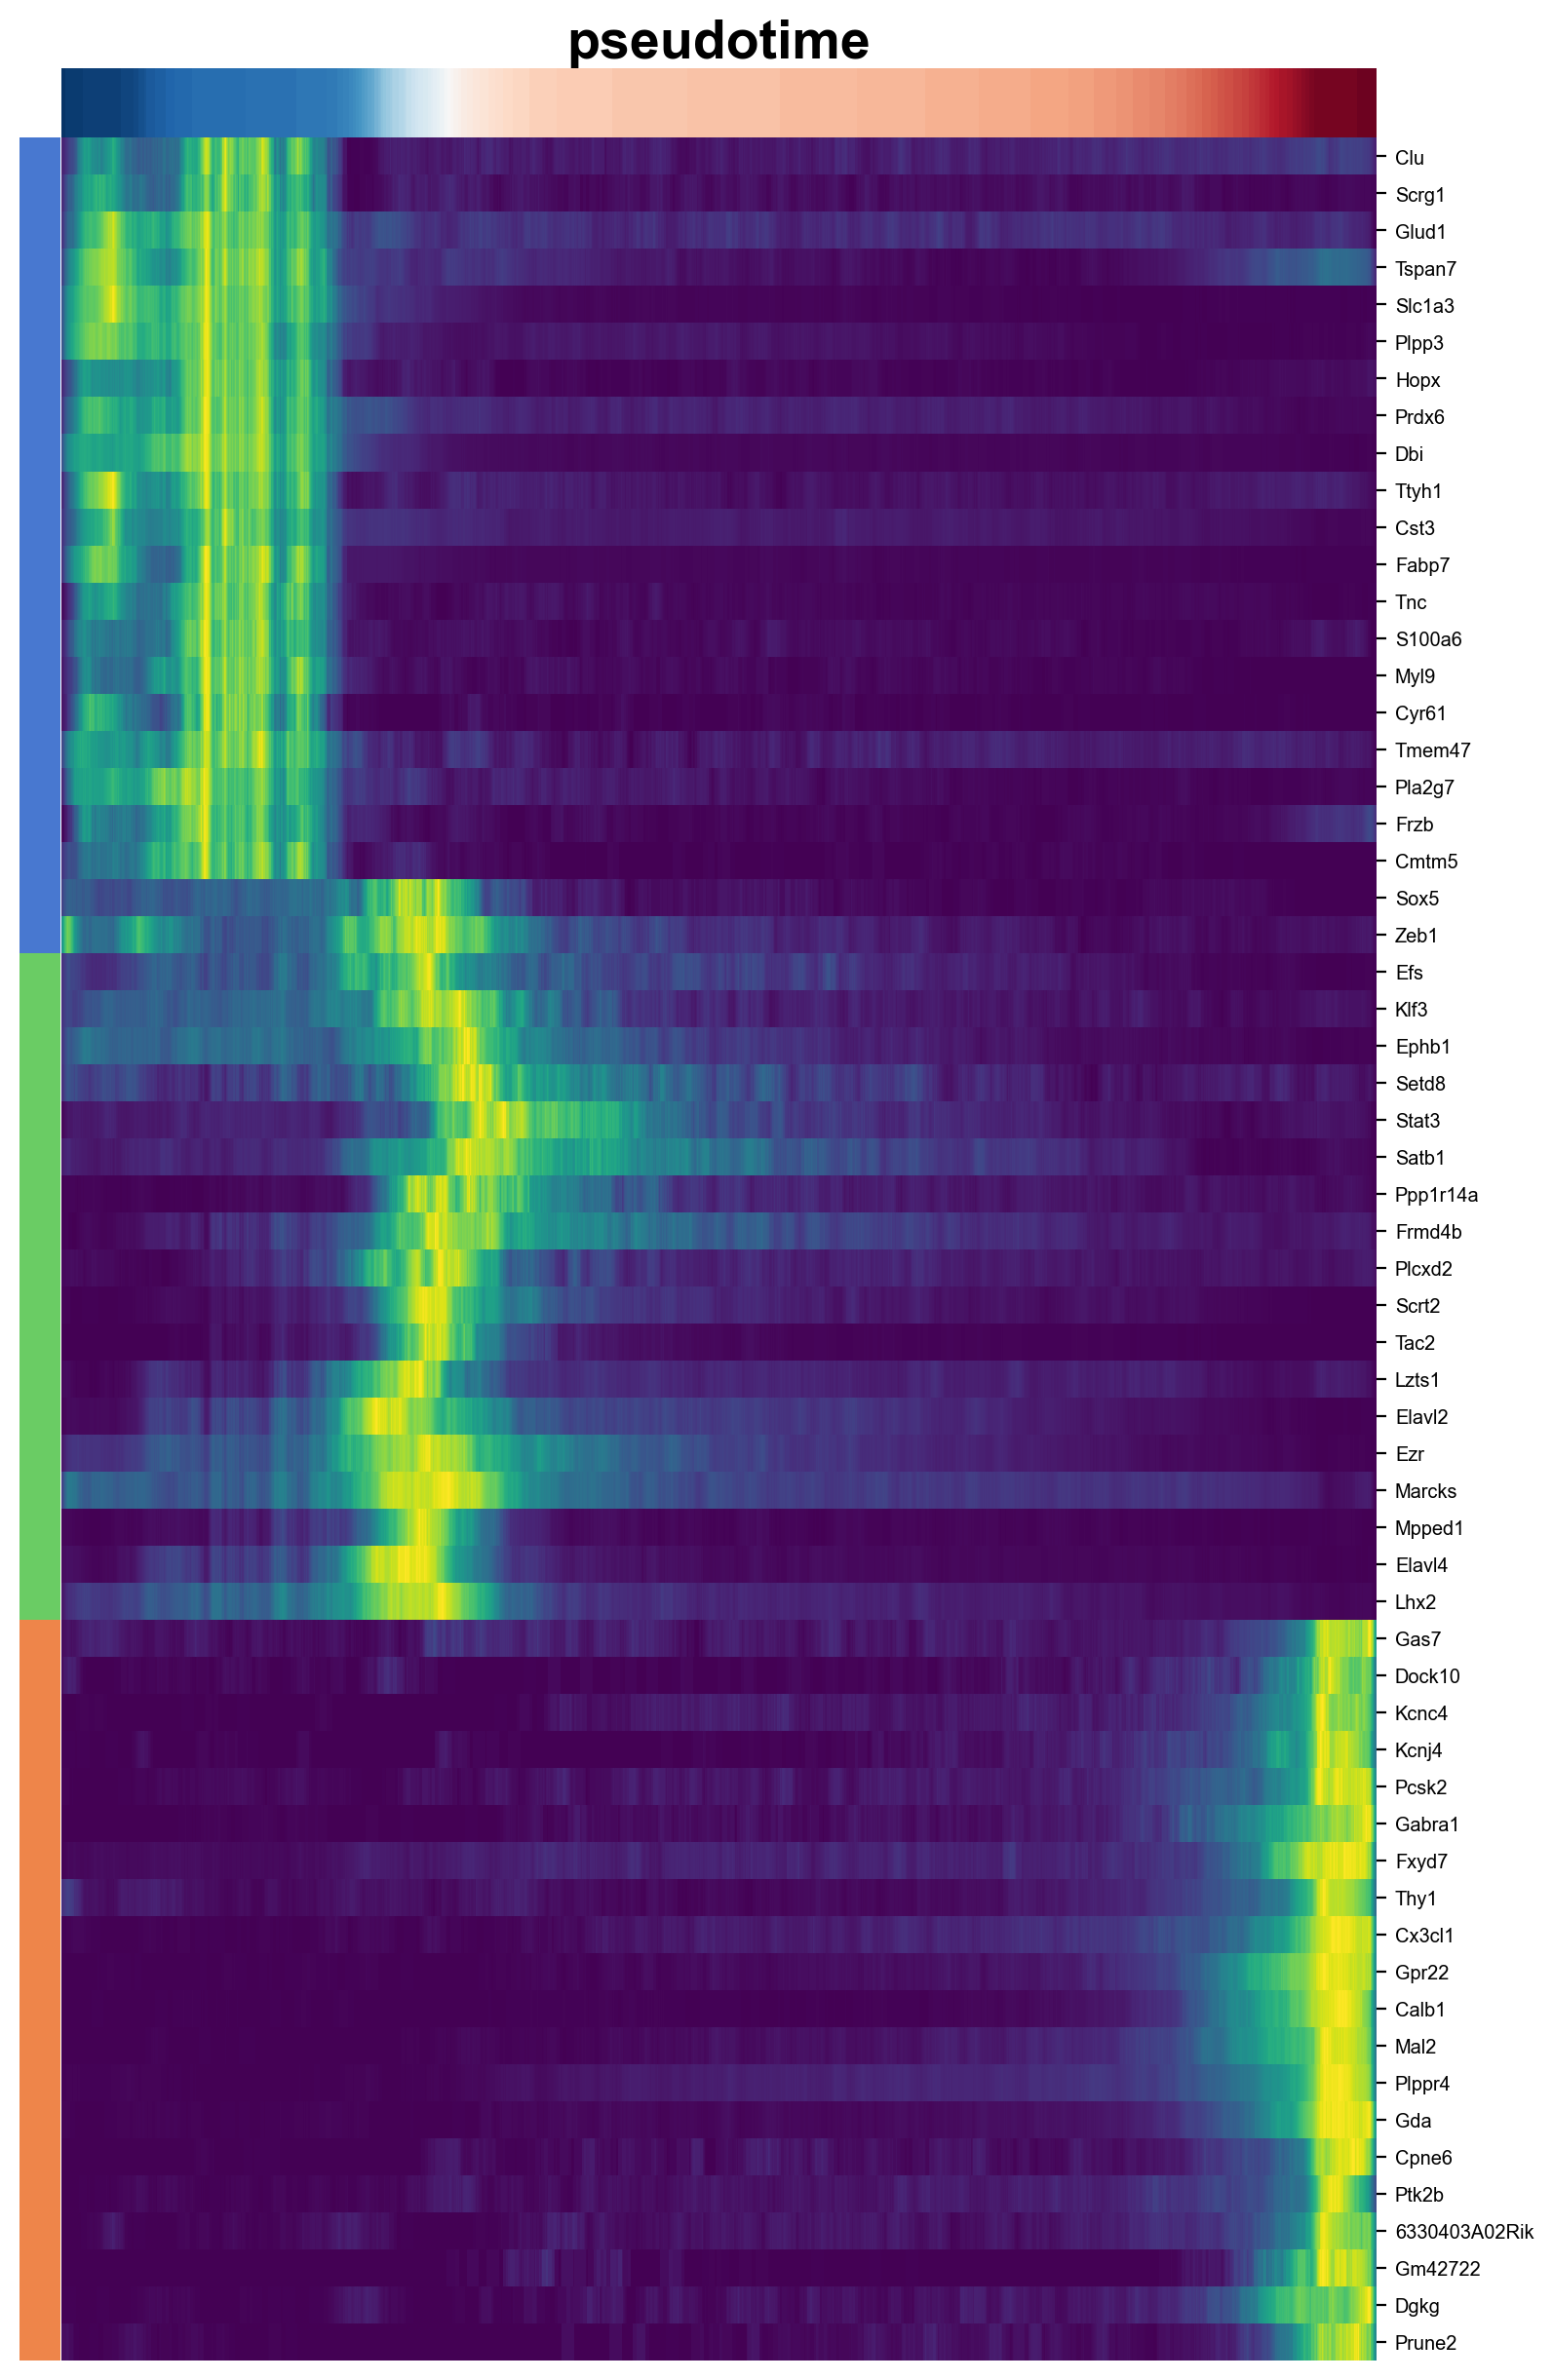

In [69]:
tkey = 'velocity_pseudotime'
n_convolve = 30

tlabels = np.arange(11)/10
tticks = np.zeros(tlabels.shape)
tkey_sorted = np.sort(adata.obs[tkey])
for i in range(len(tlabels)):
    tticks[i] = np.argmin(abs(tkey_sorted-tlabels[i]))

adata.obs['cluster'] = np.array(adata.obs['Clusters'].astype('int'))
ax = scv.pl.heatmap(adata,
               var_names=cRc_keygene,
               sort=False,
               tkey=tkey,
               n_convolve=n_convolve,
               palette=sns.color_palette("RdBu_r",n_colors=101),
               col_color=tkey,
               # row_colors=[crow_cor,crow_eg],
               row_colors=crow_eg,
               figsize=(8,12),
               show=False
#                save=result_path+'heatmap_crc_X_vpt.png'
               )
# ax.ax_col_colors.xaxis.tick_top()
# ax.ax_col_colors.set_xticks(tticks,labels=tlabels,rotation=30)
ax.ax_col_colors.xaxis.set_label_position('top')
# ax.ax_col_colors.set_xlabel('information length',fontsize=15)  
ax.ax_col_colors.set_xlabel('pseudotime',fontsize=20,weight='bold')  
ax.figure.savefig(figure_path+'5d.png',dpi=600,bbox_inches='tight')